# Segmentación de Imágenes (UNet, UNet preentrenada con ImageNet y UNet like)
**Yamil Ernesto Morfa**



## Descargar datos

In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Checar recursos y GPU

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Jun  8 01:04:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Para no descargar los datos cada vez que se ejecute la notebook, el código debajo está en comentarios.

In [ ]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  72.4M      0  0:00:10  0:00:10 --:--:-- 72.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  45.8M      0 --:--:-- --:--:-- --:--:-- 45.7M


## Preparando los directorios y caminos de las imagenes

In [ ]:
base_dir = '/content/drive/MyDrive/tarea_8'
input_dir = "images/"
target_dir = "annotations/trimaps"
img_size = (160, 160) ## Dimansión para entrenar
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

In [ ]:
import numpy as np

for i in np.random.randint(0,20, 5):
  example = PIL.Image.open(input_img_paths[i]) 
  print(np.array(example).shape)

(404, 500, 3)
(319, 400, 3)
(367, 500, 3)
(375, 500, 3)
(313, 450, 3)


Como podemos ver las imagenes no tienen la misma dimención. Para implementar nuesto modelo necesitamos llevarlas al mismo espacio $\left(160\times 160\times 3\right)$. Este código debajo preparar la clase Sequence para cargar y vectorizar lotes de datos. (https://keras.io/examples/vision/oxford_pets_image_segmentation/)

In [ ]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y

## UNet 


In [ ]:
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from tensorflow.keras import layers

## Bloque de convolución

Toda la arquitectura UNET consiste en el uso repetido de dos convoluciones de $3 \times 3$, cada una seguida de una activación de ReLU

In [ ]:
def conv_block(input, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same")(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(rate=0.25)(x)
    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(rate=0.25)(x)
    return x

In [ ]:
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

In [ ]:
def decoder_block(input, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [ ]:
def build_unet(input_shape):
    inputs = keras.Input(input_shape)

    s1, p1 = encoder_block(inputs, 96)
    s2, p2 = encoder_block(p1, 144)
    s3, p3 = encoder_block(p2, 192)
    s4, p4 = encoder_block(p3, 556)

    b1 = conv_block(p4, 1112)

    d1 = decoder_block(b1, s4, 556)
    d2 = decoder_block(d1, s3, 192)
    d3 = decoder_block(d2, s2, 144)
    d4 = decoder_block(d3, s1, 96)

    outputs = layers.Conv2D(3, 3, padding="same", activation="sigmoid")(d4)

    model = keras.Model(inputs, outputs, name="U-Net")
    return model

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 160, 96) 2688        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 160, 160, 96) 384         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 160, 160, 96) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

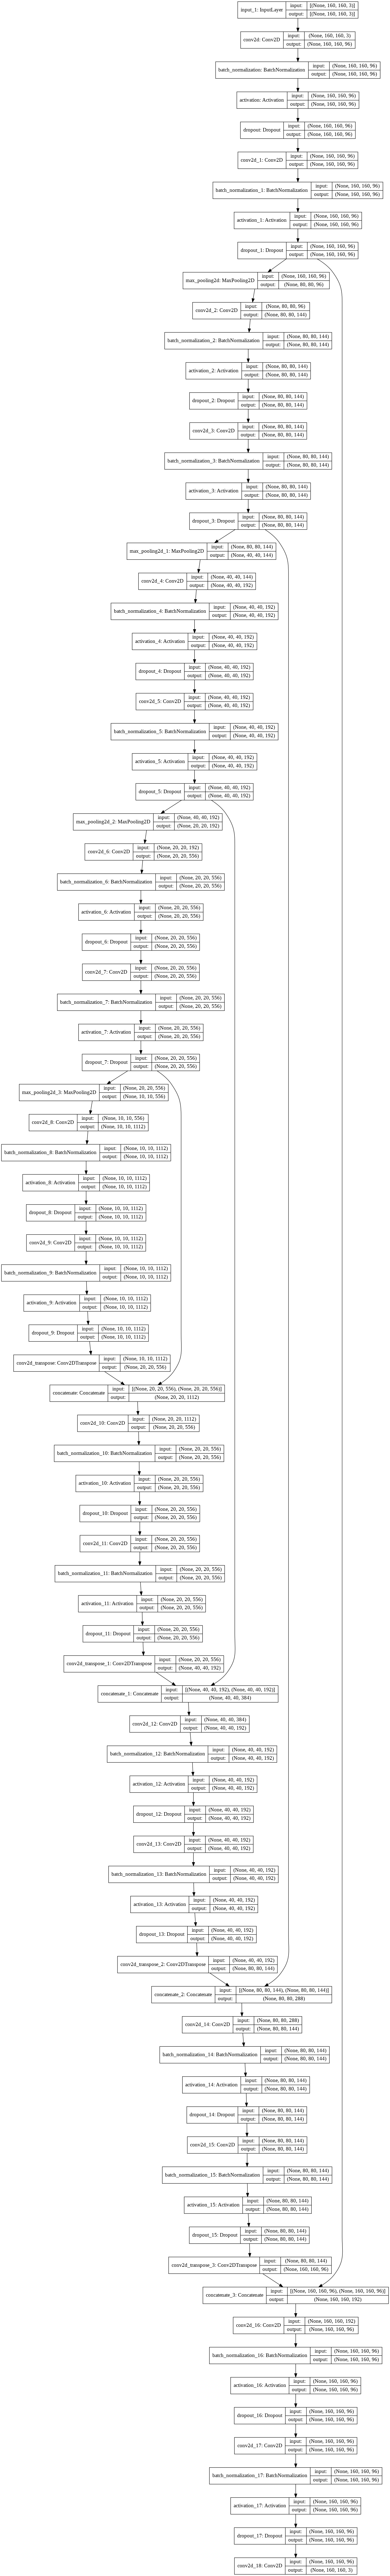

In [ ]:
unet = build_unet((160,160,3))
unet.summary()
plot_model(unet, show_shapes=True)

In [ ]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)


In [ ]:
unet.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
history = unet.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)


Epoch 1/15
199/199 [==============================] - 91s 336ms/step - loss: 0.7481 - val_loss: 1.7879
Epoch 2/15
199/199 [==============================] - 67s 334ms/step - loss: 0.5738 - val_loss: 1.0364
Epoch 3/15
199/199 [==============================] - 67s 335ms/step - loss: 0.4996 - val_loss: 0.6886
Epoch 4/15
199/199 [==============================] - 67s 334ms/step - loss: 0.4396 - val_loss: 0.7694
Epoch 5/15
199/199 [==============================] - 67s 334ms/step - loss: 0.3970 - val_loss: 0.4857
Epoch 6/15
199/199 [==============================] - 67s 335ms/step - loss: 0.3672 - val_loss: 0.4745
Epoch 7/15
199/199 [==============================] - 67s 335ms/step - loss: 0.3431 - val_loss: 0.3812
Epoch 8/15
199/199 [==============================] - 67s 335ms/step - loss: 0.3258 - val_loss: 0.4179
Epoch 9/15
199/199 [==============================] - 67s 335ms/step - loss: 0.3094 - val_loss: 0.4584
Epoch 10/15
199/199 [==============================] - 67s 336ms/step - l


 prediction time for the valitation dataset image: 5.781707048416138 seconds


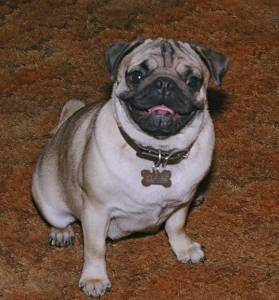

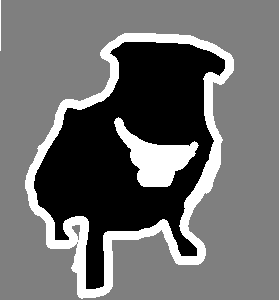

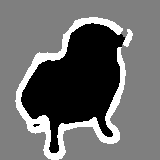

In [ ]:
import time 

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

tic = time.time()
val_preds = unet.predict(val_gen)
print('\n prediction time for the valitation dataset image:', time.time()-tic, 'seconds')

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# imagen de entrada
display(Image(filename=val_input_img_paths[i]))

# ground-truth
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# prediccion de nuestro modelo
display_mask(i) 

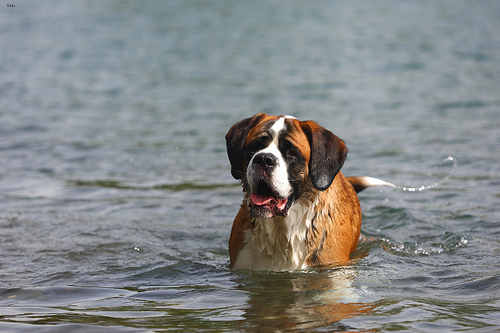

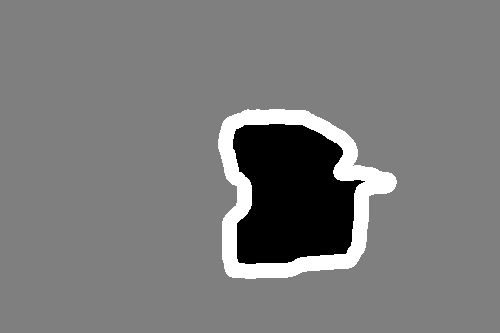

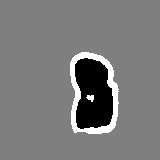

In [ ]:
# Display results for validation image #10
i = 0

# imagen de entrada
display(Image(filename=val_input_img_paths[i]))

# ground-truth
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# prediccion de nuestro modelo
display_mask(i) 

In [ ]:
loss = history.history['loss']
acc  = history.history['val_loss']

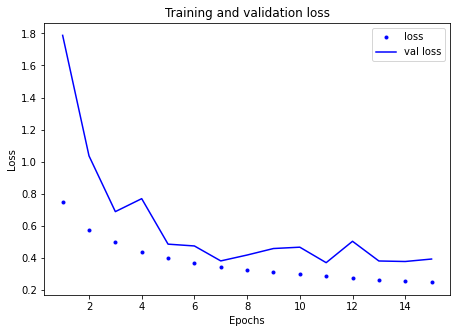

In [ ]:
epochs = range(1, len(loss) + 1)
plt.figure(2, figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'b.', label='loss')
plt.plot(epochs, acc, 'b', label='val loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
unet.save(base_dir + '/UNet_pets.h5')  

## UNet prenetrada con ImageNet

El modelo que se utiliza aquí es un U-Net modificado. Un U-Net consta de un codificador (encoder_block) y un decodificador (decoder_block). Para aprender características robustas y reducir el número de parámetros entrenables, se puede utilizar un modelo previamente entrenado como codificador. Por lo tanto, el codificador para esta tarea será un modelo MobileNetV2 previamente entrenado, cuyas salidas intermedias se utilizarán, y el decodificador será el bloque de muestra superior ya implementado en TensorFlow Examples en el tutorial de Pix2pix .

In [ ]:
pip install -q git+https://github.com/tensorflow/examples.git


In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

In [ ]:
import tensorflow as tf

base_model = tf.keras.applications.MobileNetV2(input_shape=[160, 160, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 80x80
    'block_3_expand_relu',   # 40x40
    'block_6_expand_relu',   # 20x20
    'block_13_expand_relu',  # 10x10
    'block_16_project',      # 5x5
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]


9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False


In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 5x5 -> 10x10
    pix2pix.upsample(256, 3),  # 10x0 -> 20x20
    pix2pix.upsample(128, 3),  # 20x20 -> 40x40
    pix2pix.upsample(64, 3),   # 40x40 -> 80x80
]


In [ ]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[160, 160, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 80, 80, 96), 1841984     input_3[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 10, 10, 512)  1476608     model[0][4]                      
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 10, 10, 1088) 0           sequential[0][0]                 
                                                                 model[0][3]                

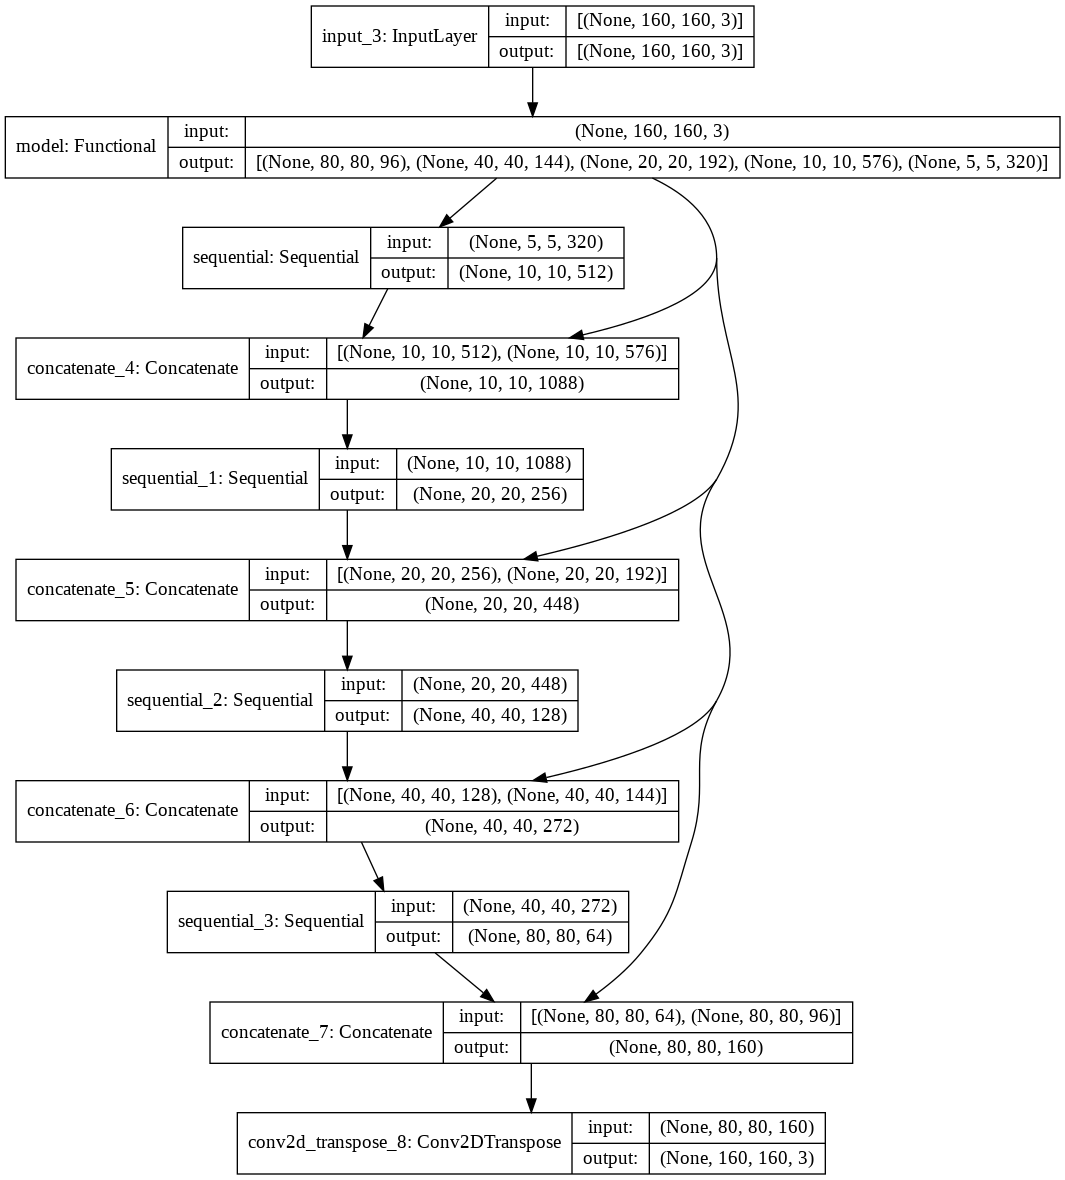

In [ ]:
unet_m = unet_model(3)
unet_m.summary()
plot_model(unet_m, show_shapes=True)

In [ ]:
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

tic = time.time()
val_preds = unet_m.predict(val_gen)
print('\n prediction time for the valitation dataset image:', time.time()-tic, 'seconds')



 prediction time for the valitation dataset image: 6.291419267654419 seconds


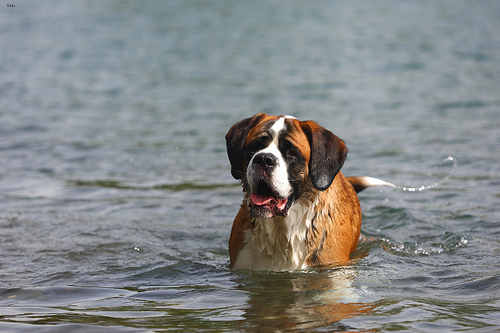

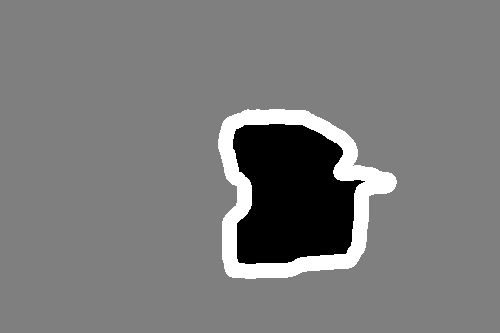

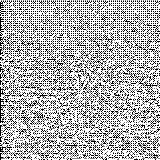

In [ ]:
# Display results for validation image #10
i = 0

# imagen de entrada
display(Image(filename=val_input_img_paths[i]))

# ground-truth
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# prediccion de nuestro modelo
display_mask(i) 

In [ ]:

unet_m.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Train the model, doing validation at the end of each epoch.
epochs = 15
history1 = unet_m.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)


Epoch 1/15
199/199 [==============================] - 41s 192ms/step - loss: 0.6105 - accuracy: 0.3018 - val_loss: 0.5188 - val_accuracy: 0.3309
Epoch 2/15
199/199 [==============================] - 37s 188ms/step - loss: 0.5006 - accuracy: 0.3111 - val_loss: 0.4925 - val_accuracy: 0.3329
Epoch 3/15
199/199 [==============================] - 37s 187ms/step - loss: 0.4737 - accuracy: 0.3121 - val_loss: 0.4973 - val_accuracy: 0.3637
Epoch 4/15
199/199 [==============================] - 37s 186ms/step - loss: 0.4601 - accuracy: 0.3124 - val_loss: 0.4629 - val_accuracy: 0.3013
Epoch 5/15
199/199 [==============================] - 37s 186ms/step - loss: 0.4475 - accuracy: 0.3122 - val_loss: 0.5005 - val_accuracy: 0.3584
Epoch 6/15
199/199 [==============================] - 37s 184ms/step - loss: 0.4404 - accuracy: 0.3116 - val_loss: 0.4640 - val_accuracy: 0.2814
Epoch 7/15
199/199 [==============================] - 37s 186ms/step - loss: 0.4270 - accuracy: 0.3118 - val_loss: 0.4527 - val_ac

In [ ]:
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

tic = time.time()
val_preds = unet_m.predict(val_gen)
print('\n prediction time for the valitation dataset image:', time.time()-tic, 'seconds')



 prediction time for the valitation dataset image: 5.987088203430176 seconds


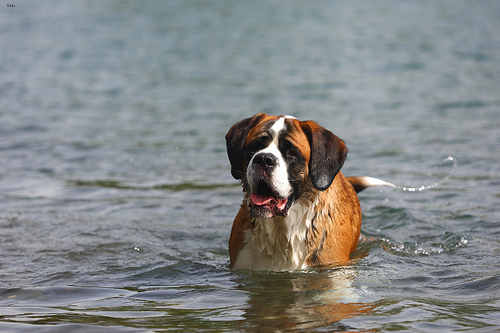

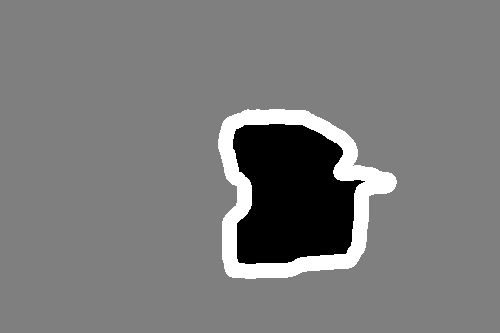

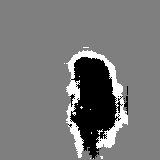

In [ ]:
# Display results for validation image #10
i = 0

# imagen de entrada
display(Image(filename=val_input_img_paths[i]))

# ground-truth
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# prediccion de nuestro modelo
display_mask(i) 

In [ ]:
loss = history1.history['loss']
acc  = history1.history['val_loss']

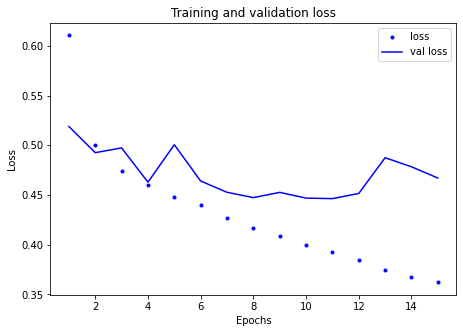

In [ ]:
epochs = range(1, len(loss) + 1)
plt.figure(2, figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'b.', label='loss')
plt.plot(epochs, acc, 'b', label='val loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
unet_m.save(base_dir + '/UNet_ImageNet_pets.h5')  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
unet_like = get_model(img_size, num_classes)
unet_like.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# Train the model, doing validation at the end of each epoch.
unet_like.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
epochs = 15
history2 = unet_like.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)


Epoch 1/15
199/199 [==============================] - 42s 190ms/step - loss: 0.9098 - val_loss: 1.7415
Epoch 2/15
199/199 [==============================] - 37s 188ms/step - loss: 0.5027 - val_loss: 2.4173
Epoch 3/15
199/199 [==============================] - 37s 186ms/step - loss: 0.4257 - val_loss: 0.4413
Epoch 4/15
199/199 [==============================] - 37s 186ms/step - loss: 0.3806 - val_loss: 0.4191
Epoch 5/15
199/199 [==============================] - 37s 185ms/step - loss: 0.3481 - val_loss: 0.4060
Epoch 6/15
199/199 [==============================] - 37s 186ms/step - loss: 0.3190 - val_loss: 0.3740
Epoch 7/15
199/199 [==============================] - 37s 185ms/step - loss: 0.2949 - val_loss: 0.3791
Epoch 8/15
199/199 [==============================] - 37s 186ms/step - loss: 0.2729 - val_loss: 0.3908
Epoch 9/15
199/199 [==============================] - 37s 186ms/step - loss: 0.2540 - val_loss: 0.3730
Epoch 10/15
199/199 [==============================] - 37s 184ms/step - l

In [ ]:
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

tic = time.time()
val_preds = unet_like.predict(val_gen)
print('\n prediction time for the valitation dataset image:', time.time()-tic, 'seconds')


 prediction time for the valitation dataset image: 5.166265964508057 seconds


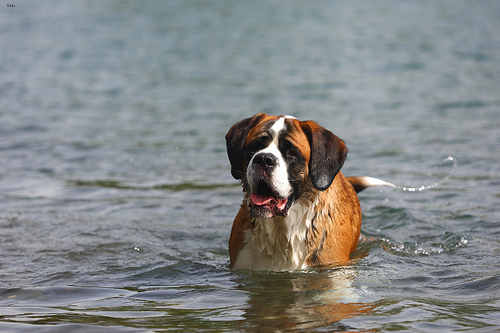

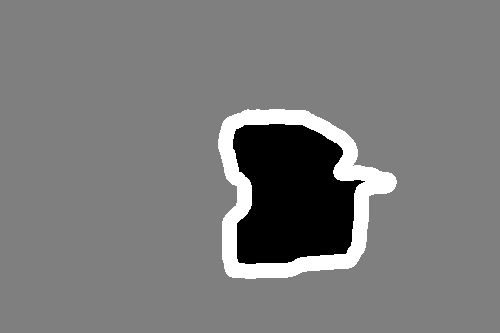

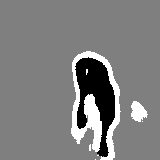

In [ ]:
# Display results for validation image #10
i = 0

# imagen de entrada
display(Image(filename=val_input_img_paths[i]))

# ground-truth
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# prediccion de nuestro modelo
display_mask(i) 

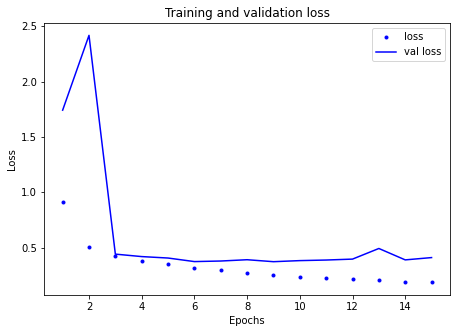

In [ ]:
loss = history2.history['loss']
acc  = history2.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure(2, figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'b.', label='loss')
plt.plot(epochs, acc, 'b', label='val loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## Comparación


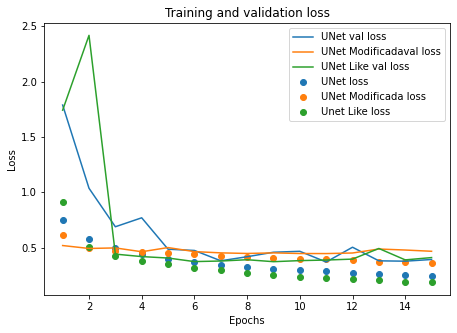

In [ ]:
loss1 = history.history['loss']
loss2 =  history1.history['loss']
loss3 =  history2.history['loss']
val_loss1  = history.history['val_loss']
val_loss2  = history1.history['val_loss']
val_loss3  = history2.history['val_loss']

epochs = range(1, len(loss1) + 1)
plt.figure(2, figsize=(16,5))
plt.subplot(1,2,1)
plt.scatter(epochs, loss1, label='UNet loss')
plt.scatter(epochs, loss2, label='UNet Modificada loss')
plt.scatter(epochs, loss3,  label='Unet Like loss')
plt.plot(epochs, val_loss1, label='UNet val loss')
plt.plot(epochs, val_loss2, label='UNet Modificadaval loss')
plt.plot(epochs, val_loss3, label='UNet Like val loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

15